In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import load_config, perform_statistical_tests

In [3]:
from features import (
    LowLevelFeatureExtractor, 
    HighLevelFeatureExtractor, 
    plot_low_level_feature_dist, 
    plot_high_level_feature_dist, 
    perform_pca_and_plot,
    perform_kernel_pca_and_plot,
    perform_pca_and_plot_3d
)

In [6]:
config    = load_config()
cache_dir = config['data_paths']['codecfake']['cache_files']
wavefake_features_dir = config['data_paths']['wavefake']['features']
codecfake_features_dir = config['data_paths']['codecfake']['features']

In [9]:
df_list = []
for features_dir in [wavefake_features_dir, codecfake_features_dir]:
    for feature_csv in os.listdir(features_dir):
        df_path = os.path.join(features_dir, feature_csv)
        df = pd.read_csv(df_path)
        df_list.append(df)

In [10]:
high_level_features_df = pd.concat(df_list, ignore_index=True)
high_level_features_df

audio_id real_or_fake  spectral_centroid_mean  \
0       LJ028-0143          WF1             1874.133940   
1       LJ028-0143          WF2             1896.024231   
2       LJ028-0143          WF3             1918.827899   
3       LJ028-0143          WF4             1871.877706   
4       LJ028-0143          WF5             1939.824198   
...            ...          ...                     ...   
350873    p314_156          F04             1337.380425   
350874    p314_156          F01             1573.130617   
350875    p314_156          F05             1404.163017   
350876    p314_156          F02             1409.657239   
350877    p314_156          F06             1345.193416   

        spectral_centroid_std  spectral_centroid_var  spectral_centroid_min  \
0                 1345.530923           1.810453e+06             526.534014   
1                 1357.514810           1.842846e+06             585.883222   
2                 1370.524166           1.878336e+06             550.249874   
3                 1335.658077           1.783982e+06             515.918819   
4                 1358.239585           1.844815e+06             555.707767   
...                       ...                    ...                    ...   
350873            1021.819819           1.044116e+06             250.743396   
350874             959.458767           9.205611e+05             349.037462   
350875            1031.342504           1.063667e+06             330.701295   
350876             997.790570           9.955860e+05             377.951428   
350877            1025.648344           1.051955e+06             258.225552   

        spectral_centroid_max  spectral_centroid_range  \
0                 6285.029512              5758.495498   
1                 6304.308256              5718.425035   
2                 6265.837711              5715.587837   
3                 6277.746003              5761.827184   
4                 6259.423582              5703.715815   
...                       ...                      ...   
350873            4879.914369              4629.170973   
350874            4654.306761              4305.269300   
350875            5011.955662              4681.254367   
350876            4507.966454              4130.015025   
350877            4769.513529              4511.287978   

        spectral_centroid_25th_percentile  spectral_centroid_50th_percentile  \
0                              975.050304                        1345.562364   
1                              985.413912                        1390.383399   
2                             1007.631444                        1414.627604   
3                              974.725797                        1356.723998   
4                             1010.880341                        1418.982549   
...                                   ...                                ...   
350873                         538.439611                        1162.905724   
350874                         917.060593                        1323.939333   
350875                         623.925784                        1158.009799   
350876                         629.267745                        1097.131971   
350877                         498.694222                        1120.322029   

        ...  shimmer_dda        hnr  voicedcount  npause  originaldur  \
0       ...     0.099888  11.673236         32.0     2.0     7.360726   
1       ...     0.096005  12.024721         29.0     2.0     7.360726   
2       ...     0.111386  11.691639         30.0     2.0     7.349116   
3       ...     0.088301  12.341544         33.0     2.0     7.360726   
4       ...     0.109853  11.311680         32.0     2.0     7.360726   
...     ...          ...        ...          ...     ...          ...   
350873  ...     0.114114  11.130743         12.0     0.0     3.426667   
350874  ...     0.094717  12.820312         12.0     0.0     2.754125   
350875  ...     0.094615  12.227384  

In [16]:
high_level_features_df.drop_duplicates(subset=['audio_id', 'real_or_fake']).shape

(350878, 410)

In [1]:
# high_level_features_df.columns[high_level_features_df.isna().sum() > 0]

In [12]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

def select_features(features_df, target_column='real_or_fake', method='random_forest', k=10):
    X = features_df.drop(columns=['audio_id', target_column])
    y = features_df[target_column]

    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns)
    
    if method == 'anova':
        selector = SelectKBest(f_classif, k=k)
        selector.fit(X, y)
        selected_features = X.columns[selector.get_support()]
    elif method == 'rfe':
        model = RandomForestClassifier(random_state=42)
        selector = RFE(model, n_features_to_select=k)
        selector.fit(X, y)
        selected_features = X.columns[selector.get_support()]
    else: 
        
        model = RandomForestClassifier(random_state=42)
        model.fit(X, y)
        feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
        selected_features = feature_importances.head(k).index

    return selected_features

#### F01 vs R

In [13]:
features_df = high_level_features_df[high_level_features_df['real_or_fake'].isin(['R', 'F01'])].reset_index()

In [14]:
selected_features = select_features(features_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_bandwidth_min', 'spectral_contrast_mean',
       'spectral_contrast_std', 'spectral_contrast_var',
       'spectral_contrast_max', 'spectral_contrast_range',
       'spectral_contrast_50th_percentile',
       'spectral_contrast_75th_percentile', 'spectral_contrast_skew',
       'spectral_contrast_kurtosis'],
      dtype='object')

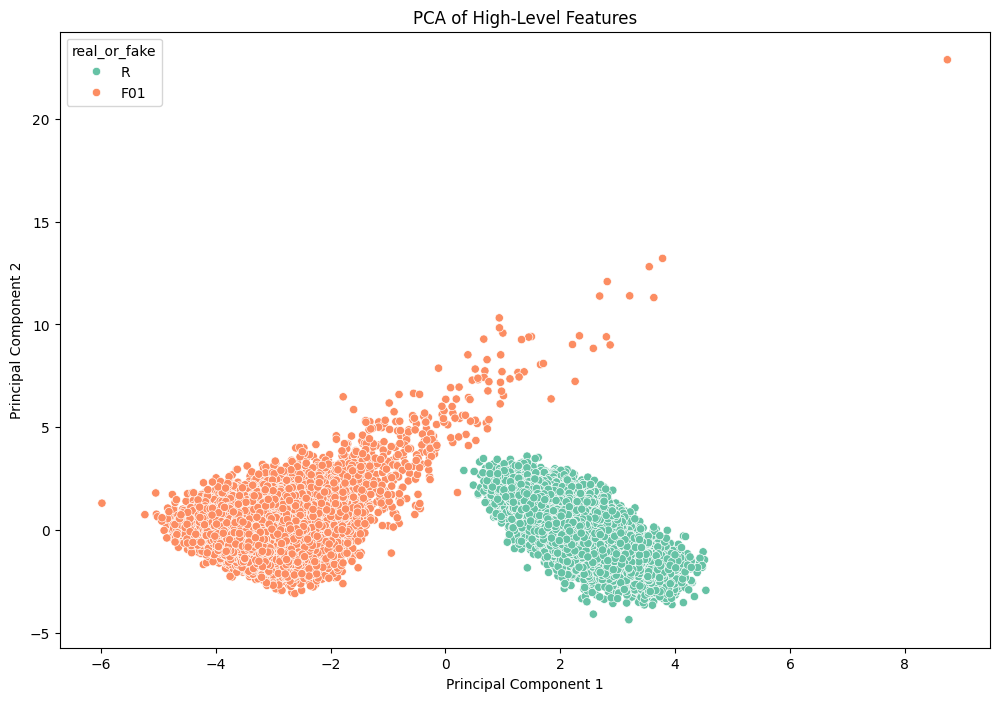

In [15]:
perform_pca_and_plot(features_df, selected_features)

#### F02 vs R

In [19]:
features_df = high_level_features_df[high_level_features_df['real_or_fake'].isin(['R', 'F02'])].reset_index()

In [20]:
selected_features = select_features(features_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_mean', 'spectral_contrast_std',
       'spectral_contrast_var', 'spectral_contrast_max',
       'spectral_contrast_range', 'spectral_contrast_25th_percentile',
       'spectral_contrast_50th_percentile',
       'spectral_contrast_75th_percentile', 'spectral_contrast_skew',
       'spectral_flatness_max'],
      dtype='object')

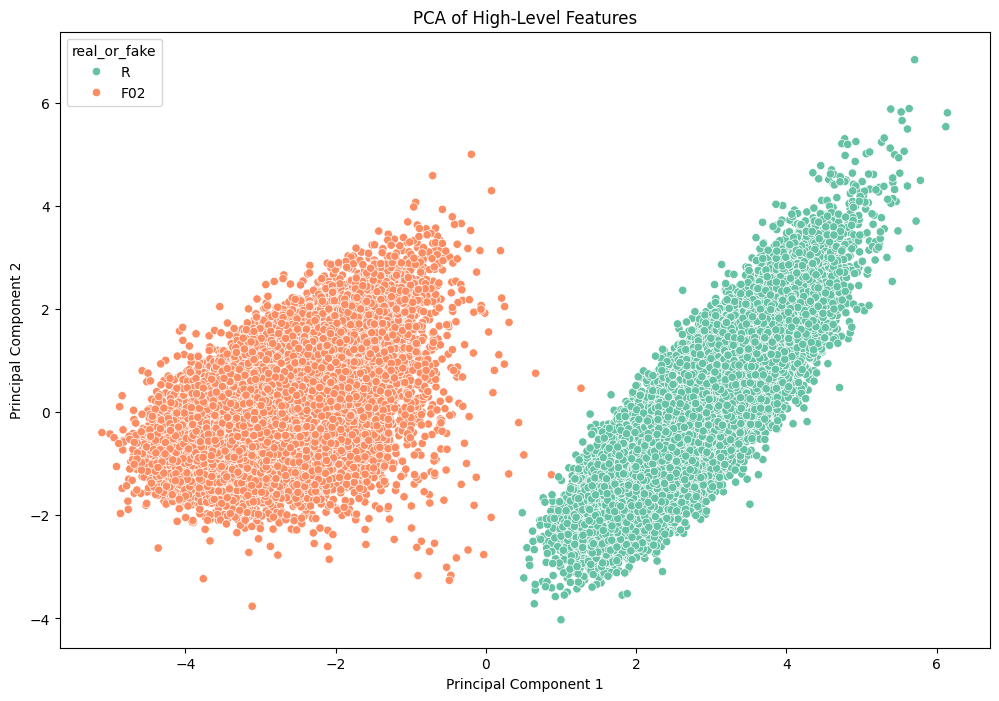

In [14]:
perform_pca_and_plot(features_df, selected_features)

#### F03 vs R

In [15]:
features_df = high_level_features_df[high_level_features_df['real_or_fake'].isin(['R', 'F03'])].reset_index()

In [16]:
selected_features = select_features(features_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_mean', 'spectral_contrast_std',
       'spectral_contrast_var', 'spectral_contrast_max',
       'spectral_contrast_range', 'spectral_contrast_skew',
       'spectral_flux_std', 'energy_std', 'energy_max', 'energy_range'],
      dtype='object')

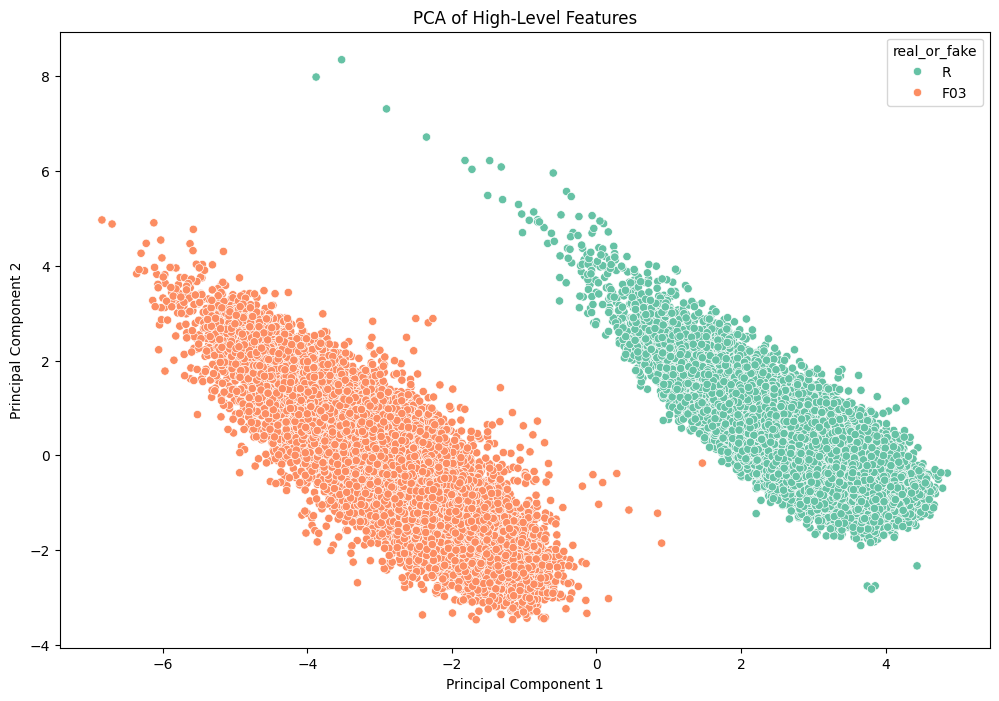

In [17]:
perform_pca_and_plot(features_df, selected_features)

#### F04 vs R

In [18]:
features_df = high_level_features_df[high_level_features_df['real_or_fake'].isin(['R', 'F04'])].reset_index()

In [19]:
selected_features = select_features(features_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_bandwidth_25th_percentile', 'spectral_contrast_std',
       'spectral_contrast_var', 'spectral_contrast_75th_percentile',
       'spectral_contrast_skew', 'spectral_contrast_kurtosis', 'shimmer_local',
       'shimmer_apq3', 'shimmer_apq5', 'shimmer_dda'],
      dtype='object')

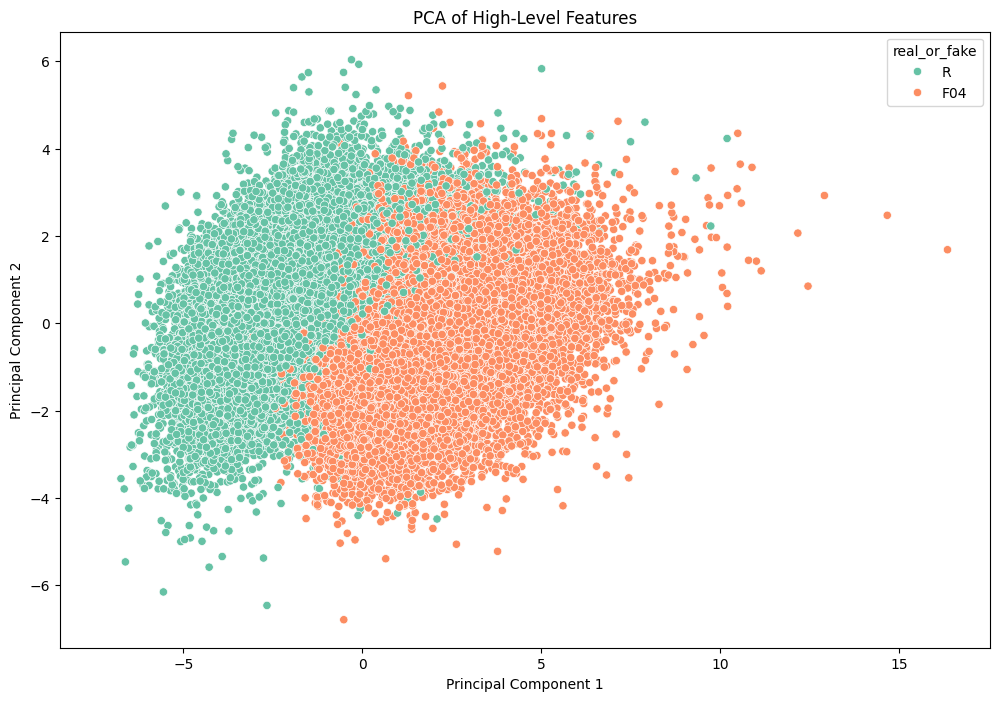

In [20]:
perform_pca_and_plot(features_df, selected_features)

#### F05 vs R

In [22]:
features_df = high_level_features_df[high_level_features_df['real_or_fake'].isin(['R', 'F05'])].reset_index()

In [23]:
selected_features = select_features(features_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_mean', 'spectral_contrast_max',
       'spectral_contrast_range', 'spectral_contrast_25th_percentile',
       'spectral_contrast_50th_percentile',
       'spectral_contrast_75th_percentile', 'spectral_contrast_skew',
       'spectral_contrast_kurtosis', 'jitter_rap', 'jitter_ppq5'],
      dtype='object')

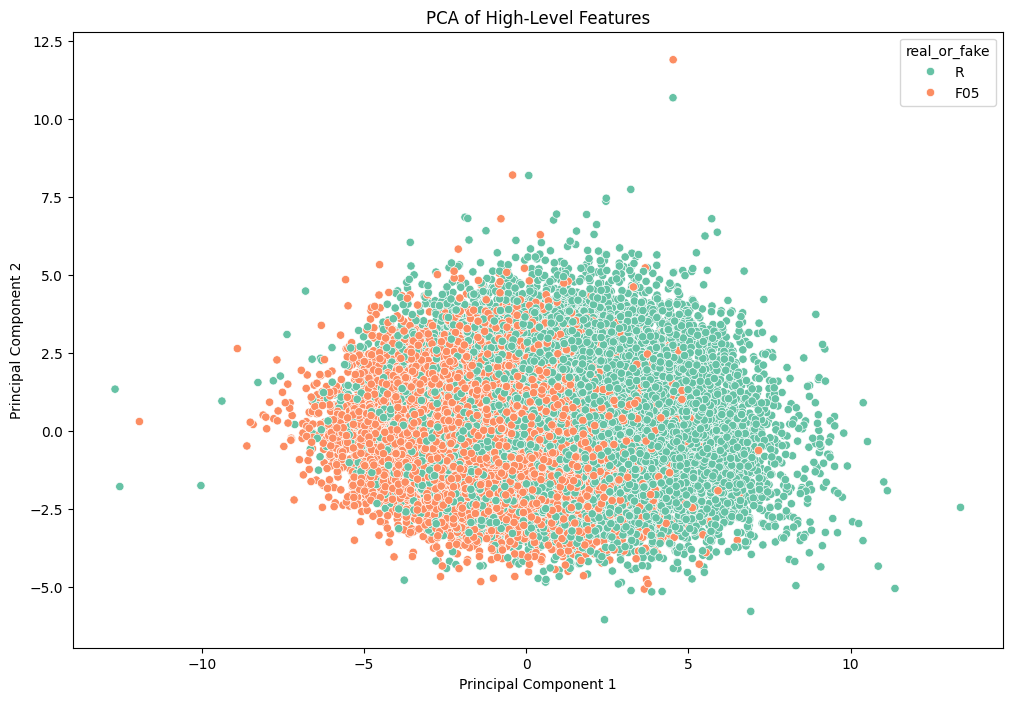

In [44]:
perform_pca_and_plot(features_df, selected_features)

#### F06 vs R

In [46]:
features_df = high_level_features_df[high_level_features_df['real_or_fake'].isin(['R', 'F06'])].reset_index()

In [47]:
selected_features = select_features(features_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_mean', 'spectral_contrast_std',
       'spectral_contrast_var', 'spectral_contrast_max',
       'spectral_contrast_range', 'spectral_contrast_skew',
       'spectral_flux_std', 'energy_std', 'energy_max', 'energy_range'],
      dtype='object')

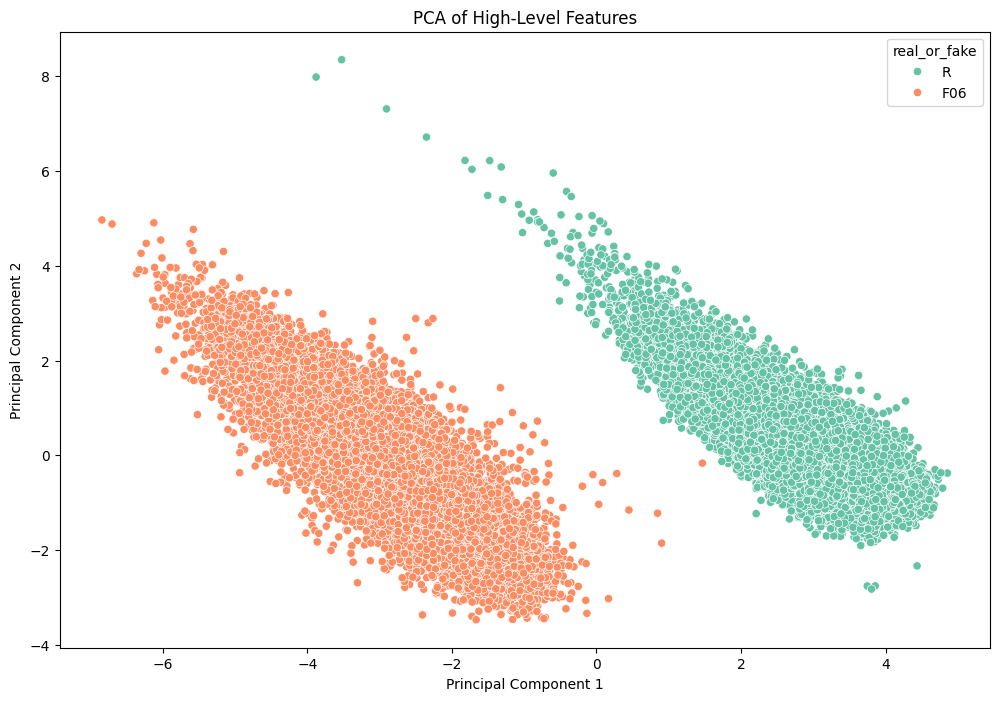

In [48]:
perform_pca_and_plot(features_df, selected_features)

In [49]:
features_dir = config['data_paths']['wavefake']['features']

In [66]:
df_list = []

for feature_csv in sorted(os.listdir(features_dir)):
    if not feature_csv.endswith(".csv"):
        continue
    df_path = os.path.join(features_dir, feature_csv)
    df = pd.read_csv(df_path)
    if len(df) < 800:
        print(df_path)
        continue
    df_list.append(df)

/app/data/features/wavefake/wavefake_features_partition_67.csv
/app/data/features/wavefake/wavefake_features_partition_68.csv
/app/data/features/wavefake/wavefake_features_partition_69.csv
/app/data/features/wavefake/wavefake_features_partition_70.csv
/app/data/features/wavefake/wavefake_features_partition_71.csv
/app/data/features/wavefake/wavefake_features_partition_72.csv
/app/data/features/wavefake/wavefake_features_partition_73.csv
/app/data/features/wavefake/wavefake_features_partition_74.csv
/app/data/features/wavefake/wavefake_features_partition_75.csv
/app/data/features/wavefake/wavefake_features_partition_76.csv
/app/data/features/wavefake/wavefake_features_partition_77.csv
/app/data/features/wavefake/wavefake_features_partition_78.csv
/app/data/features/wavefake/wavefake_features_partition_79.csv
/app/data/features/wavefake/wavefake_features_partition_80.csv
/app/data/features/wavefake/wavefake_features_partition_81.csv
/app/data/features/wavefake/wavefake_features_partition

In [67]:
high_level_features_df = pd.concat(df_list, ignore_index=True)
high_level_features_df

audio_id real_or_fake  spectral_centroid_mean  spectral_centroid_std  \
0      LJ001-0001          WF1             2215.761314            1504.498621   
1      LJ001-0001          WF2             2230.992328            1499.564311   
2      LJ001-0001          WF3             2262.774856            1508.413565   
3      LJ001-0001          WF4             2224.065771            1499.412349   
4      LJ001-0001          WF5             2315.957312            1518.028363   
...           ...          ...                     ...                    ...   
79195  LJ038-0118          WF4             2092.080332            1338.325708   
79196  LJ038-0118          WF5             2171.467920            1344.040791   
79197  LJ038-0118          WF6             2107.356718            1370.166501   
79198  LJ038-0118          WF7             2141.407598            1377.685092   
79199  LJ038-0118            R             2146.281916            1351.163643   

       spectral_centroid_var  spectral_centroid_min  spectral_centroid_max  \
0               2.263516e+06             620.229114            6272.318749   
1               2.248693e+06             631.340809            6311.683591   
2               2.275311e+06             620.585346            6381.098339   
3               2.248237e+06             639.523601            6309.773475   
4               2.304410e+06             656.353758            6380.084194   
...                      ...                    ...                    ...   
79195           1.791116e+06             619.380982            6427.105596   
79196           1.806446e+06             627.114263            6364.143065   
79197           1.877356e+06             618.779955            6493.095747   
79198           1.898016e+06             626.360326            6457.460936   
79199           1.825643e+06             632.645241            6464.622496   

       spectral_centroid_range  spectral_centroid_25th_percentile  \
0                  5652.089635                        1138.741777   
1                  5680.342782                        1130.303670   
2                  5760.512994                        1160.747485   
3                  5670.249874                        1146.827344   
4                  5723.730436                        1202.714536   
...                        ...                                ...   
79195              5807.724614                        1413.127873   
79196              5737.028802                        1414.012426   
79197              5874.315792                        1344.899052   
79198              5831.100610                        1397.277975   
79199              5831.977256                        1416.186159   

       spectral_centroid_50th_percentile  ...  shimmer_dda        hnr  \
0                            1571.916321  ...     0.090894  12.053586   
1                            1605.547933  ...     0.087833  12.545062   
2                            1644.220480  ...     0.095503  12.098844   
3                            1571.074673  ...     0.078993  12.806330   
4                            1682.224534  ...     0.095421  11.435125   
...                                  ...  ...          ...        ...   
79195                        1629.697016  ...     0.075508  12.966730   
79196                        1744.694677  ...     0.082744  11.497125   
79197                        1673.276595  ...     0.096048  12.589408   
79198                        1679.836761  ...     0.094422  11.597066   
79199                        1698.915938  ...     0.084001  12.835041   

       voicedcount  npause  originaldur  intensity_duration  speakingrate  \
0               43       1     9.659501            9.659501      4.451576   
1               36       1     9.659501            9.659501      3.726901   
2               40       1     9.647891            9.647891      4.145984   
3               45       1     9.659501            9.659501      4.658626   
4       

### WF1 vs R

In [68]:
features_df = high_level_features_df[high_level_features_df['real_or_fake'].isin(['R', 'WF1'])].reset_index()

In [70]:
selected_features = select_features(features_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_mean', 'spectral_contrast_max',
       'spectral_contrast_range', 'spectral_contrast_50th_percentile',
       'spectral_contrast_75th_percentile', 'jitter_ppq5', 'shimmer_local',
       'speakingrate', 'articulationrate', 'asd'],
      dtype='object')

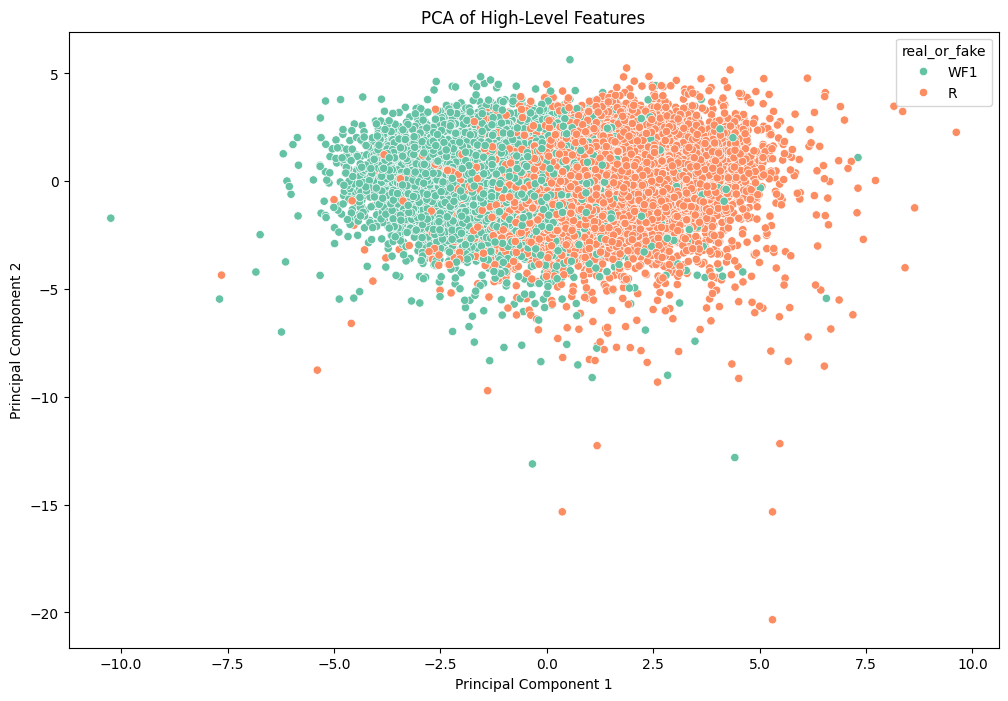

In [71]:
perform_pca_and_plot(features_df, selected_features)

### WF2 vs R

In [72]:
features_df = high_level_features_df[high_level_features_df['real_or_fake'].isin(['R', 'WF2'])].reset_index()

In [73]:
selected_features = select_features(features_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_mean', 'spectral_contrast_25th_percentile',
       'spectral_contrast_50th_percentile',
       'spectral_contrast_75th_percentile', 'spectral_contrast_skew',
       'spectral_contrast_kurtosis', 'spectral_flatness_mean', 'jitter_local',
       'jitter_rap', 'jitter_ppq5'],
      dtype='object')

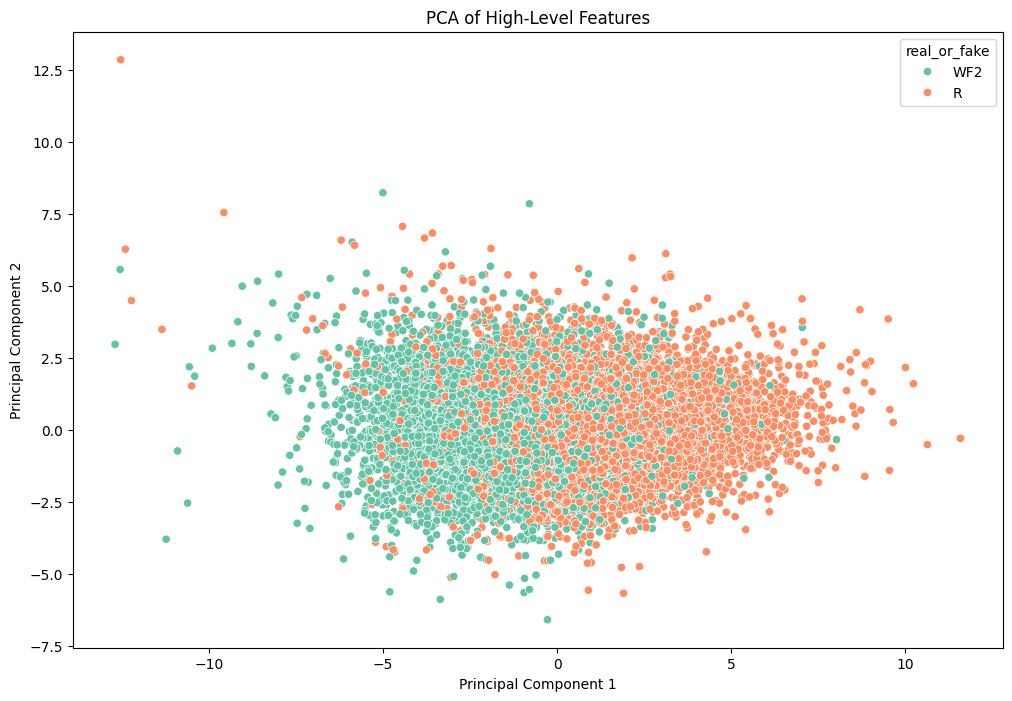

In [74]:
perform_pca_and_plot(features_df, selected_features)

### WF3 vs R

In [76]:
features_df = high_level_features_df[high_level_features_df['real_or_fake'].isin(['R', 'WF3'])].reset_index()

In [77]:
selected_features = select_features(features_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [225 356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_mean', 'spectral_contrast_25th_percentile',
       'spectral_contrast_50th_percentile',
       'spectral_contrast_75th_percentile', 'spectral_contrast_skew',
       'spectral_contrast_kurtosis', 'jitter_rap', 'jitter_ppq5',
       'shimmer_apq3', 'shimmer_dda'],
      dtype='object')

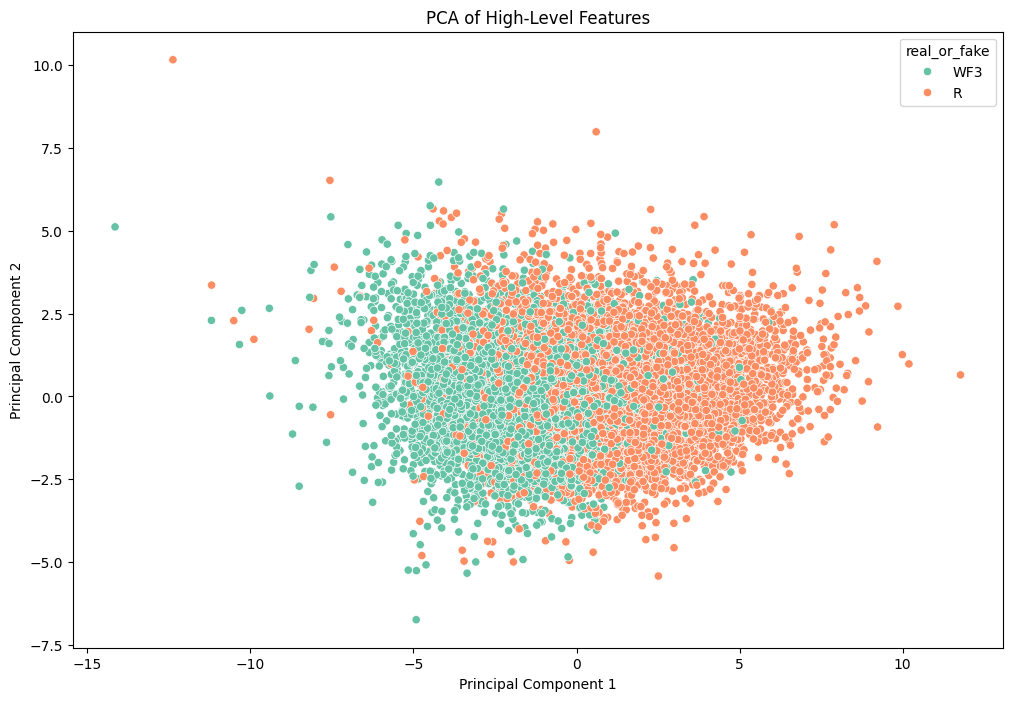

In [78]:
perform_pca_and_plot(features_df, selected_features)

### WF4 vs R

In [79]:
features_df = high_level_features_df[high_level_features_df['real_or_fake'].isin(['R', 'WF4'])].reset_index()

In [80]:
selected_features = select_features(features_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [280 324 356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_std', 'spectral_contrast_var',
       'spectral_contrast_max', 'spectral_contrast_range',
       'spectral_contrast_25th_percentile', 'shimmer_apq3', 'shimmer_dda',
       'speakingrate', 'articulationrate', 'asd'],
      dtype='object')

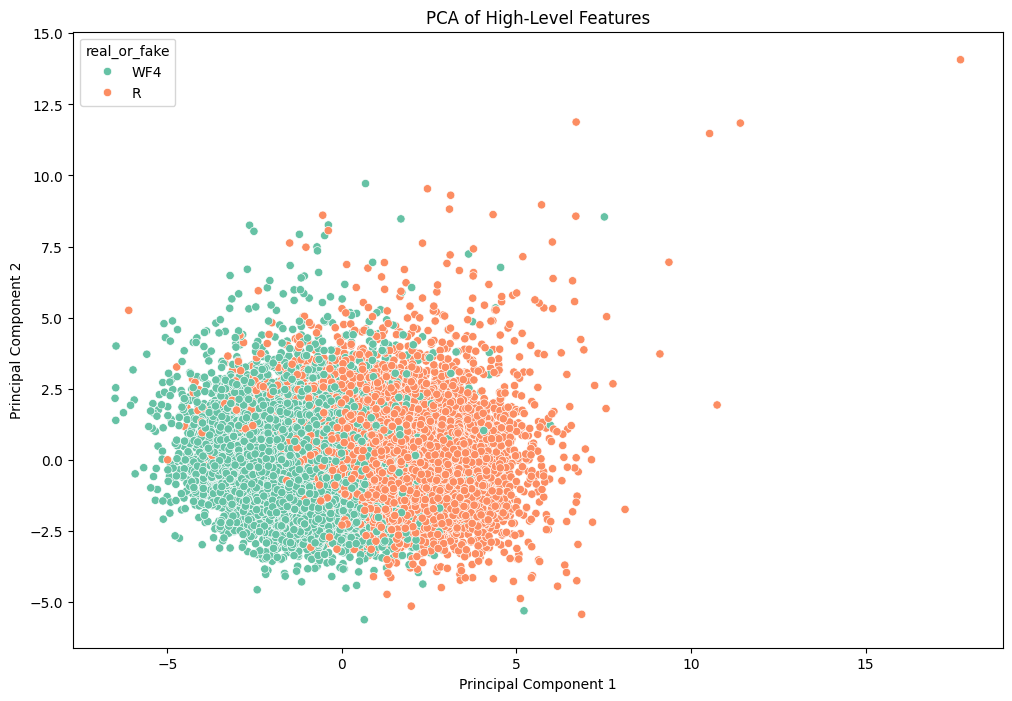

In [81]:
perform_pca_and_plot(features_df, selected_features)

### WF5 vs R

In [82]:
features_df = high_level_features_df[high_level_features_df['real_or_fake'].isin(['R', 'WF5'])].reset_index()

In [83]:
selected_features = select_features(features_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [225 356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_mean', 'spectral_contrast_25th_percentile',
       'spectral_contrast_50th_percentile',
       'spectral_contrast_75th_percentile', 'spectral_contrast_skew',
       'spectral_contrast_kurtosis', 'mfcc_4_75th_percentile', 'jitter_rap',
       'jitter_ppq5', 'hnr'],
      dtype='object')

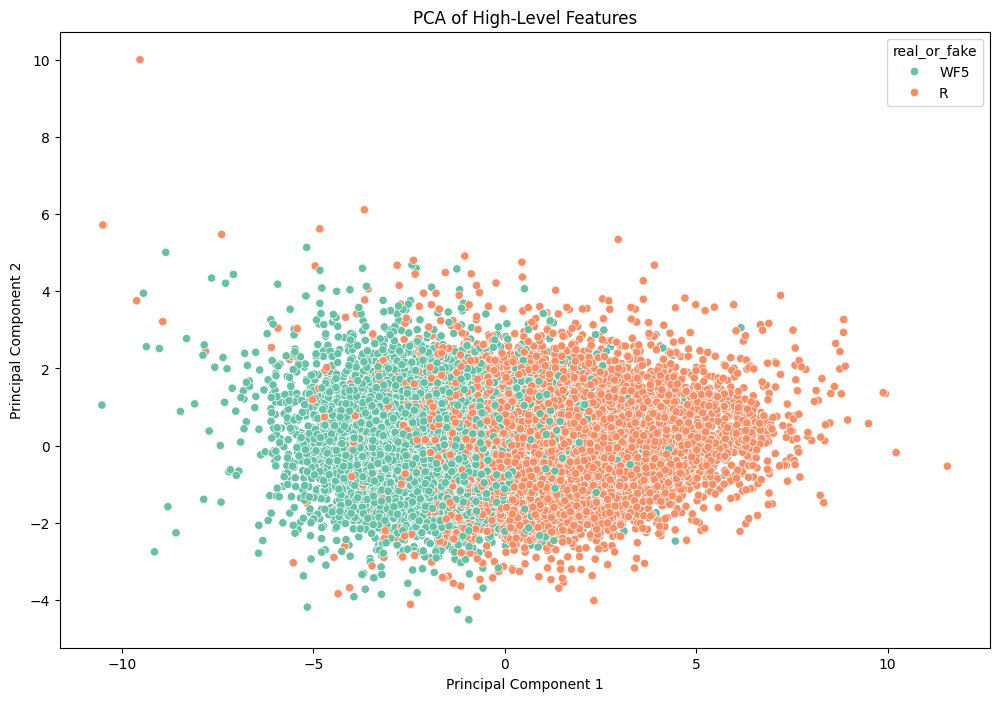

In [84]:
perform_pca_and_plot(features_df, selected_features)

### WF6 vs R

In [85]:
features_df = high_level_features_df[high_level_features_df['real_or_fake'].isin(['R', 'WF6'])].reset_index()

In [86]:
selected_features = select_features(features_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [225 356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_mean', 'spectral_contrast_50th_percentile',
       'spectral_contrast_75th_percentile', 'spectral_contrast_skew',
       'spectral_contrast_kurtosis', 'spectral_flux_mean', 'energy_mean',
       'energy_75th_percentile', 'jitter_rap', 'jitter_ppq5'],
      dtype='object')

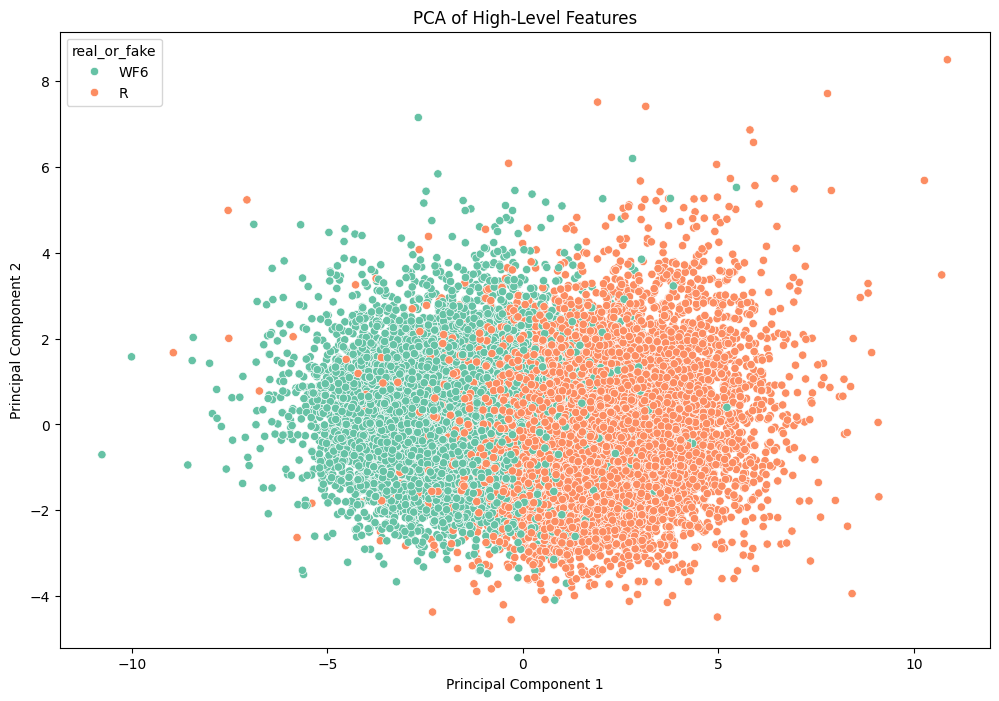

In [87]:
perform_pca_and_plot(features_df, selected_features)

### WF7 vs R

In [88]:
features_df = high_level_features_df[high_level_features_df['real_or_fake'].isin(['R', 'WF7'])].reset_index()

In [89]:
selected_features = select_features(features_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [225 356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_mean', 'spectral_contrast_25th_percentile',
       'spectral_contrast_50th_percentile',
       'spectral_contrast_75th_percentile', 'spectral_contrast_skew',
       'spectral_contrast_kurtosis', 'shimmer_local', 'shimmer_apq3',
       'shimmer_apq5', 'shimmer_dda'],
      dtype='object')

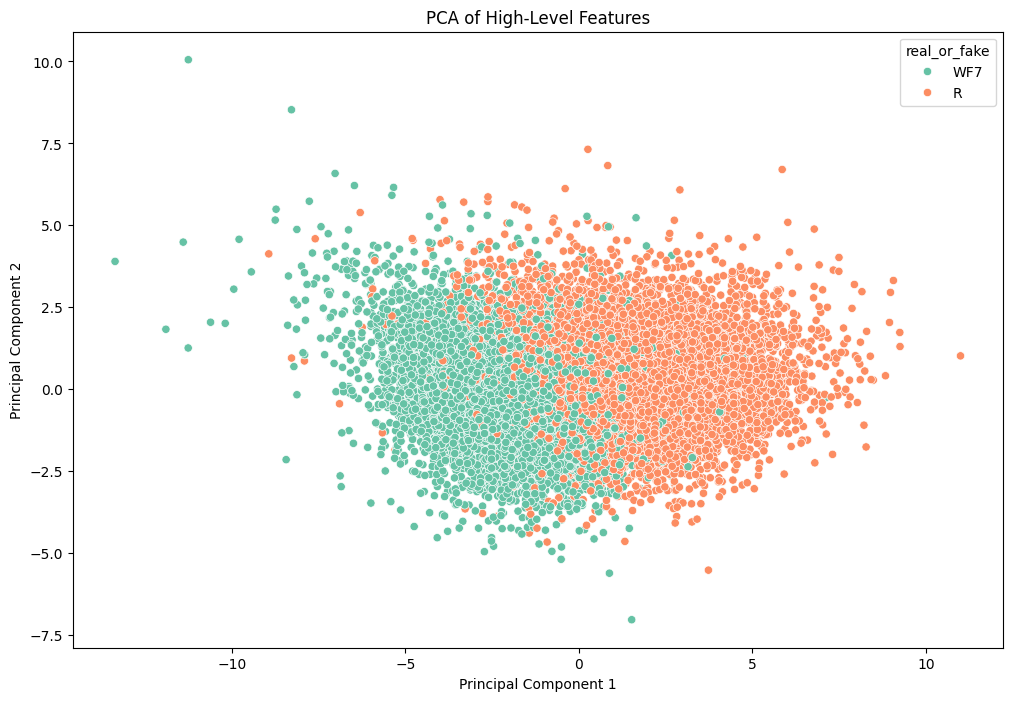

In [90]:
perform_pca_and_plot(features_df, selected_features)